In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px
import warnings
from math import atan,cos,sin,degrees,atan2,isclose,tan,radians,sqrt,pi
import math

from lib.io import load_pickle_data
from lib.kalman_filter import generate_kalmanfilter,apply_kalmanfilter
from lib.noglobal import noglobal


from external_lib.visualize import visualize_trafic
from external_lib.gnss_transformer import load_gnss_data_from_file,gnss_log_to_dataframes


warnings.filterwarnings('ignore')


from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd

In [2]:
target_collection = '2021-04-29-US-SJC-2'
train_df_path = "/work/data/input/selfmade_dataset/baseline_with_derived_data_v2/train.pkl";



train_df = load_pickle_data(train_df_path)
train_df["collectionName"] = train_df["phone"].apply(lambda x: x.split("_")[0])

target_train_df = train_df[train_df["collectionName"] == target_collection];


header = ["latDeg","lngDeg"];

#kf = generate_kalmanfilter();

#target_train_df[header] = apply_kalmanfilter(target_train_df[header].to_numpy(),kf)
visualize_trafic(target_train_df)

train_df = load_pickle_data(train_df_path)
train_df["collectionName"] = train_df["phone"].apply(lambda x: x.split("_")[0])

target_train_df = train_df[train_df["collectionName"] == target_collection];


header = ["latDeg","lngDeg"];

kf = generate_kalmanfilter();

target_train_df[header] = apply_kalmanfilter(target_train_df[header].to_numpy(),kf)
visualize_trafic(target_train_df)

In [3]:
train_df = load_pickle_data(train_df_path)
train_df["collectionName"] = train_df["phone"].apply(lambda x: x.split("_")[0])

target_train_df = train_df[train_df["collectionName"] == target_collection];


header = ["latDeg","lngDeg"];

kf = generate_kalmanfilter();

target_train_df[header] = target_train_df[["latDeg_gt","lngDeg_gt"]]
#visualize_trafic(target_train_df)

In [4]:
def SS_fit(data):
    x = data[:,[0]]
    y = data[:,[1]]
    z = data[:,[2]]
    
    data_len = len(x);
    
    x2 = np.power(x,2);
    y2 = np.power(y,2);
    z2 = np.power(z,2);
    
    r1 = -x*(x2+y2+z2)
    r2= -y*(x2+y2+z2)
    r3 = -z*(x2+y2+z2)
    r4 = -(x2+y2+z2)
    
    left = np.array([[np.sum(x2),np.sum(x*y),np.sum(x*z),np.sum(x)],
                     [np.sum(x*y),np.sum(y2),np.sum(y*z),np.sum(y)],
                     [np.sum(x*z),np.sum(y*z),np.sum(z2),np.sum(z)],
                     [np.sum(x), np.sum(y), np.sum(z), data_len]])
    
    right = np.array([np.sum(r1),
                      np.sum(r2),
                      np.sum(r3),
                      np.sum(r4)])
    
    si = np.linalg.inv(left) @ right

    x0 = (-1/2)* si[0]
    y0 = (-1/2)* si[1]
    z0 = (-1/2)* si[2]
    
    return np.array([x0,y0,z0])
    
    
@noglobal()
def vincenty_inverse(lat1, lon1, lat2, lon2):

    # Not advanced
    if isclose(lat1, lat2) and isclose(lon1, lon2):
        return False
    
    # WGS84
    a = 6378137.0
    ƒ = 1 / 298.257223563
    b = (1 - ƒ) * a

    lat_1 = atan((1 - ƒ) * tan(radians(lat1)))
    lat_2 = atan((1 - ƒ) * tan(radians(lat2)))
    
    lon_diff = radians(lon2) - radians(lon1)
    λ = lon_diff

    for i in range(1000):
        sinλ = sin(λ)
        cosλ = cos(λ)
        sinσ = sqrt((cos(lat_2) * sinλ) ** 2 + (cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ) ** 2)
        cosσ = sin(lat_1) * sin(lat_2) + cos(lat_1) * cos(lat_2) * cosλ
        σ = atan2(sinσ, cosσ)
        sinα = cos(lat_1) * cos(lat_2) * sinλ / sinσ
        cos2α = 1 - sinα ** 2
        cos2σm = cosσ - 2 * sin(lat_1) * sin(lat_2) / cos2α
        C = ƒ / 16 * cos2α * (4 + ƒ * (4 - 3 * cos2α))
        λʹ = λ
        λ = lon_diff + (1 - C) * ƒ * sinα * (σ + C * sinσ * (cos2σm + C * cosσ * (-1 + 2 * cos2σm ** 2)))
        
        if abs(λ - λʹ) <= 1e-12:
            break
    else:
        return None

    α = atan2(cos(lat_2) * sinλ, cos(lat_1) * sin(lat_2) - sin(lat_1) * cos(lat_2) * cosλ)

    if α < 0:
        α = α + math.pi * 2

    return degrees(α)
    
    
    
@noglobal()
def calc3(row):
    deg = - degrees(atan2(-1*row['calc2'],row['calc1']))
    if deg < 0:
        deg += 360
    return deg 
# lowpass filter

from scipy.signal import butter, lfilter

ORDER = 3
FS = 50.0
CUTOFF = 2.5

@noglobal()
def butter_lowpass(cutoff = CUTOFF, fs = FS, order=ORDER):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

@noglobal()
def butter_lowpass_filter(data, cutoff = CUTOFF, fs =FS, order=ORDER):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [5]:
target_collection = '2021-01-05-US-SVL-1'
phone = "Pixel4"
train_df_path = "/work/data/input/selfmade_dataset/baseline_with_derived_data_v2/train.pkl";

gnss_path = f"/work/data/input/google-smartphone-decimeter-challenge/train/{target_collection}/{phone}/{phone}_GnssLog.txt"

In [6]:
@noglobal()
def get_direction_by_magn(train_df,target_collection,phone):
    
    ORDER = 3
    FS = 50.0
    CUTOFF = 2.5

    
    gnss_path = f"/work/data/input/google-smartphone-decimeter-challenge/train/{target_collection}/{phone}/{phone}_GnssLog.txt"
    
    lat = "latDeg_gt"
    lng =  "lngDeg_gt"
    
    gt_df = train_df[train_df["phone"] == target_collection + "_" + phone]
    gt_path = "/".join(gnss_path.split("/")[:-1]) + "/ground_truth.csv"
    
    acce_df = load_gnss_data_from_file(gnss_path,"UncalAccel",verbose="notebook")
        
    acce_df["global_x"] = acce_df["UncalAccelZMps2"]
    acce_df["global_y"] = acce_df["UncalAccelXMps2"]
    acce_df["global_z"] = acce_df["UncalAccelYMps2"]
    
    acce_df["x_f"] = butter_lowpass_filter(acce_df["global_x"],CUTOFF,FS,ORDER)
    acce_df["y_f"] = butter_lowpass_filter(acce_df["global_y"],CUTOFF,FS,ORDER)
    acce_df["z_f"] = butter_lowpass_filter(acce_df["global_z"],CUTOFF,FS,ORDER)
        
    smooth_range = 1000
    
    acce_df["x_f"] = acce_df["x_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    acce_df["y_f"] = acce_df["y_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    acce_df["z_f"] = acce_df["z_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    
    #######################################################################################
    ################################ [magn] ###############################################
    
    mag_df = load_gnss_data_from_file(gnss_path,"UncalMag",verbose="notebook")        
    
    mag_df["global_mx"] = mag_df["UncalMagZMicroT"]
    mag_df["global_my"] = mag_df["UncalMagYMicroT"]
    mag_df["global_mz"] = mag_df["UncalMagXMicroT"]
    
    smooth_range = 1000
    
    mag_df["global_mx"] = mag_df["global_mx"].rolling(smooth_range,  min_periods=1).mean()
    mag_df["global_my"] = mag_df["global_mz"].rolling(smooth_range,  min_periods=1).mean()
    mag_df["global_mz"] = mag_df["global_my"].rolling(smooth_range,  min_periods=1).mean()
    
    
    mag_columns = ["global_mx","global_my","global_mz"]
            
    offset = SS_fit(mag_df[mag_columns].to_numpy())
    
    mag_df["global_mx"] = (mag_df["global_mx"] - offset[0])*-1
    mag_df["global_my"] = mag_df["global_my"] - offset[1]
    mag_df["global_mz"] = mag_df["global_mz"] - offset[2]    

    acce_df["millisSinceGpsEpoch"] = acce_df["millisSinceGpsEpoch"]//1000 + 10
    mag_df["millisSinceGpsEpoch"] = mag_df["millisSinceGpsEpoch"]//1000 + 10
    gt_df["millisSinceGpsEpoch"] =  gt_df["millisSinceGpsEpoch"]//1000 + 1
    
    acce_df = pd.merge_asof(acce_df.sort_values('millisSinceGpsEpoch'), 
                           mag_df[["global_mx", "global_my","global_mz","millisSinceGpsEpoch"]].sort_values('millisSinceGpsEpoch') ,on='millisSinceGpsEpoch', direction='nearest')
    
    acce_df = pd.merge_asof(gt_df[["millisSinceGpsEpoch",lat,lng]].sort_values('millisSinceGpsEpoch'), 
                           acce_df[["millisSinceGpsEpoch", "x_f","y_f","z_f","global_mx","global_my","global_mz"]].sort_values('millisSinceGpsEpoch') ,on='millisSinceGpsEpoch', direction='nearest')
            
    start_mean_range = 10
        
    x_start_mean = acce_df[:start_mean_range]["x_f"].mean()
    y_start_mean = acce_df[:start_mean_range]["y_f"].mean()
    z_start_mean = acce_df[:start_mean_range]["z_f"].mean() 
    
    r = atan(y_start_mean/z_start_mean)
    p = atan(x_start_mean/(y_start_mean**2 + z_start_mean**2)**0.5)
    
    
    acce_df["calc1"] = acce_df["global_mx"]*cos(p) + acce_df["global_my"]*sin(r)*sin(p) + acce_df["global_mz"]*sin(p)*cos(r)
    acce_df["calc2"] = acce_df["global_mz"]*sin(r) - acce_df["global_my"]*cos(r)
    acce_df["calc_deg"] = acce_df.apply(calc3, axis=1)
    
    
    acce_df["deg"] = 0
    
    gt_lat_prev = 0
    gt_lng_prev = 0
    
    for i in range(1,acce_df.shape[0]):
        if i > 1:
            res = vincenty_inverse(gt_lat_prev,gt_lng_prev,acce_df[lat].loc[i],acce_df[lng].loc[i])
            
            if res:
                acce_df["deg"].loc[i] = res
            else:
                if i > 0:
                    acce_df["deg"].loc[i] = acce_df["deg"].loc[i-1]
                else:
                    acce_df["deg"].loc[i] = 0
        
        gt_lat_prev = acce_df[lat].loc[i]
        gt_lng_prev = acce_df[lng].loc[i]
        
    
    output_mg = ["global_mx","global_my","global_mz"]
    
    
    
    return acce_df
    
    

[GNSS UncalAccel]:   0%|          | 0/149142 [00:00<?, ?it/s]

[GNSS UncalMag]:   0%|          | 0/144711 [00:00<?, ?it/s]

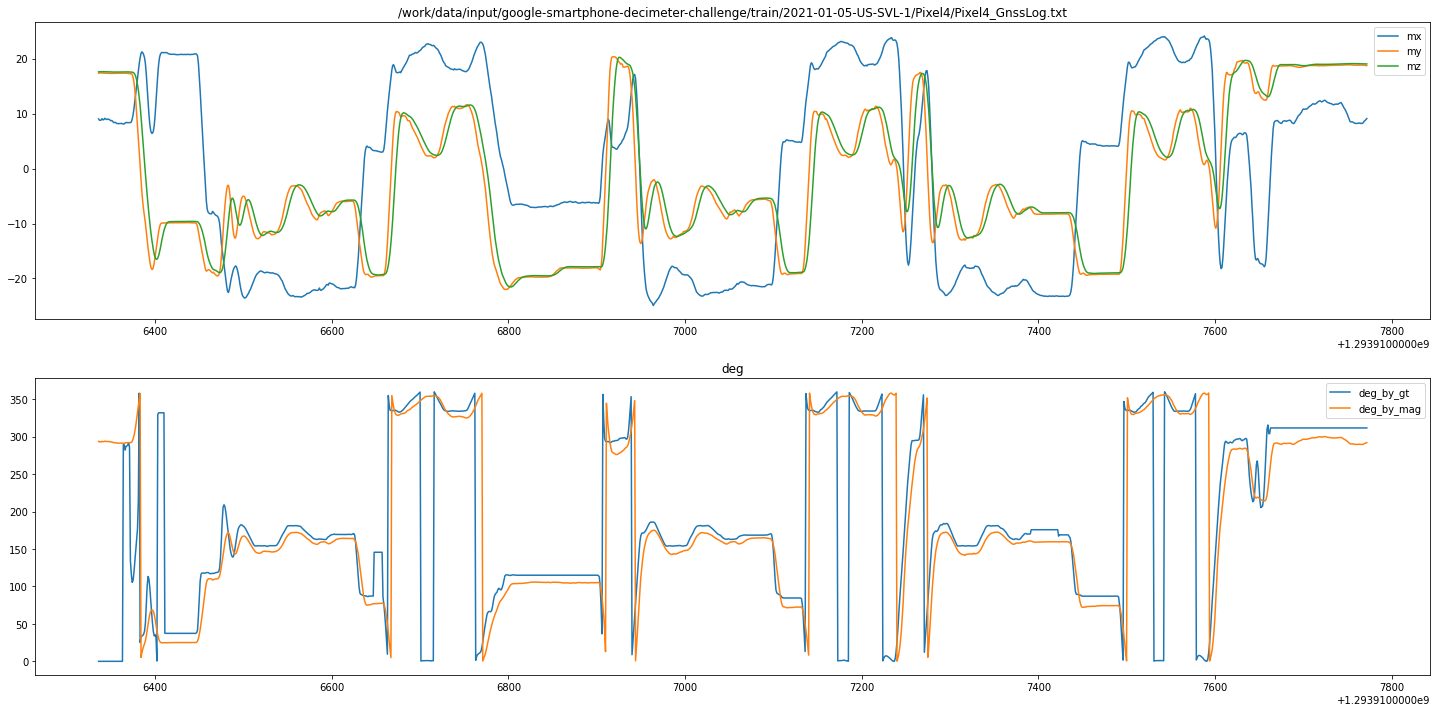

In [7]:
logg_paths = [gnss_path]

fig,ax = plt.subplots(len(logg_paths)*2, 1, figsize=(25,6*2*len(logg_paths)))

lat = "latDeg_gt"
lng =  "lngDeg_gt"

for idx,gnss_path in enumerate(logg_paths):
    
    gt_df = train_df[train_df["phone"] == target_collection + "_" + phone]
    
    gt_path = "/".join(gnss_path.split("/")[:-1]) + "/ground_truth.csv"
    
    #######################################################################################
    ################################ [acc] ###############################################
    
    acce_df = load_gnss_data_from_file(gnss_path,"UncalAccel",verbose="notebook")
        
    acce_df["global_x"] = acce_df["UncalAccelZMps2"]
    acce_df["global_y"] = acce_df["UncalAccelXMps2"]
    acce_df["global_z"] = acce_df["UncalAccelYMps2"]
    
    acce_df["x_f"] = butter_lowpass_filter(acce_df["global_x"],CUTOFF,FS,ORDER)
    acce_df["y_f"] = butter_lowpass_filter(acce_df["global_y"],CUTOFF,FS,ORDER)
    acce_df["z_f"] = butter_lowpass_filter(acce_df["global_z"],CUTOFF,FS,ORDER)
    
    smooth_range = 1000
    
    acce_df["x_f"] = acce_df["x_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    acce_df["y_f"] = acce_df["y_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    acce_df["z_f"] = acce_df["z_f"].rolling(smooth_range,center = True,min_periods=1).mean()
    
    #######################################################################################
    ################################ [magn] ###############################################
    
    mag_df = load_gnss_data_from_file(gnss_path,"UncalMag",verbose="notebook")        
    
    mag_df["global_mx"] = mag_df["UncalMagZMicroT"]
    mag_df["global_my"] = mag_df["UncalMagYMicroT"]
    mag_df["global_mz"] = mag_df["UncalMagXMicroT"]
    
    smooth_range = 1000
    
    mag_df["global_mx"] = mag_df["global_mx"].rolling(smooth_range,  min_periods=1).mean()
    mag_df["global_my"] = mag_df["global_mz"].rolling(smooth_range,  min_periods=1).mean()
    mag_df["global_mz"] = mag_df["global_my"].rolling(smooth_range,  min_periods=1).mean()
    
    
    mag_columns = ["global_mx","global_my","global_mz"]
            
    offset = SS_fit(mag_df[mag_columns].to_numpy())
    
    mag_df["global_mx"] = (mag_df["global_mx"] - offset[0])*-1
    mag_df["global_my"] = mag_df["global_my"] - offset[1]
    mag_df["global_mz"] = mag_df["global_mz"] - offset[2]
    
    
    acce_df["millisSinceGpsEpoch"] = acce_df["millisSinceGpsEpoch"]//1000 + 18
    mag_df["millisSinceGpsEpoch"] = mag_df["millisSinceGpsEpoch"]//1000 + 18
    gt_df["millisSinceGpsEpoch"] =  gt_df["millisSinceGpsEpoch"]//1000 + 1
    
    
    acce_df = pd.merge_asof(acce_df.sort_values('millisSinceGpsEpoch'), 
                           mag_df[["global_mx", "global_my","global_mz","millisSinceGpsEpoch"]].sort_values('millisSinceGpsEpoch') ,on='millisSinceGpsEpoch', direction='nearest')
    
    acce_df = pd.merge_asof(gt_df[["millisSinceGpsEpoch",lat,lng]].sort_values('millisSinceGpsEpoch'), 
                           acce_df[["millisSinceGpsEpoch", "x_f","y_f","z_f","global_mx","global_my","global_mz"]].sort_values('millisSinceGpsEpoch') ,on='millisSinceGpsEpoch', direction='nearest')
            
    start_mean_range = 10
        
    x_start_mean = acce_df[:start_mean_range]["x_f"].mean()
    y_start_mean = acce_df[:start_mean_range]["y_f"].mean()
    z_start_mean = acce_df[:start_mean_range]["z_f"].mean() 
    
    r = atan(y_start_mean/z_start_mean)
    p = atan(x_start_mean/(y_start_mean**2 + z_start_mean**2)**0.5)
    
    
    acce_df["calc1"] = acce_df["global_mx"]*cos(p) + acce_df["global_my"]*sin(r)*sin(p) + acce_df["global_mz"]*sin(p)*cos(r)
    acce_df["calc2"] = acce_df["global_mz"]*sin(r) - acce_df["global_my"]*cos(r)
    acce_df["calc_deg"] = acce_df.apply(calc3, axis=1)
    
    
    acce_df["deg"] = 0
    
    gt_lat_prev = 0
    gt_lng_prev = 0
    
    for i in range(1,acce_df.shape[0]):
        if i > 1:
            res = vincenty_inverse(gt_lat_prev,gt_lng_prev,acce_df[lat].loc[i],acce_df[lng].loc[i])
            
            if res:
                acce_df["deg"].loc[i] = res
            else:
                if i > 0:
                    acce_df["deg"].loc[i] = acce_df["deg"].loc[i-1]
                else:
                    acce_df["deg"].loc[i] = 0
        
        gt_lat_prev = acce_df[lat].loc[i]
        gt_lng_prev = acce_df[lng].loc[i]
        
    ax[2*idx].plot(acce_df["millisSinceGpsEpoch"],acce_df["global_mx"] ,label="mx")
    ax[2*idx].plot(acce_df["millisSinceGpsEpoch"],acce_df["global_my"], label="my")
    ax[2*idx].plot(acce_df["millisSinceGpsEpoch"],acce_df["global_mz"], label="mz")
    ax[2*idx].legend()
    ax[2*idx].set_title(gnss_path)
     
    ax[2*idx+1].plot(acce_df["millisSinceGpsEpoch"],acce_df["deg"] ,label="deg_by_gt")
    ax[2*idx+1].plot(acce_df["millisSinceGpsEpoch"],acce_df["calc_deg"] ,label="deg_by_mag")    
    ax[2*idx+1].legend()
    ax[2*idx+1].set_title("deg")

  0%|          | 0/1 [00:00<?, ?it/s]

[GNSS UncalAccel]:   0%|          | 0/700677 [00:00<?, ?it/s]

[GNSS UncalMag]:   0%|          | 0/171377 [00:00<?, ?it/s]

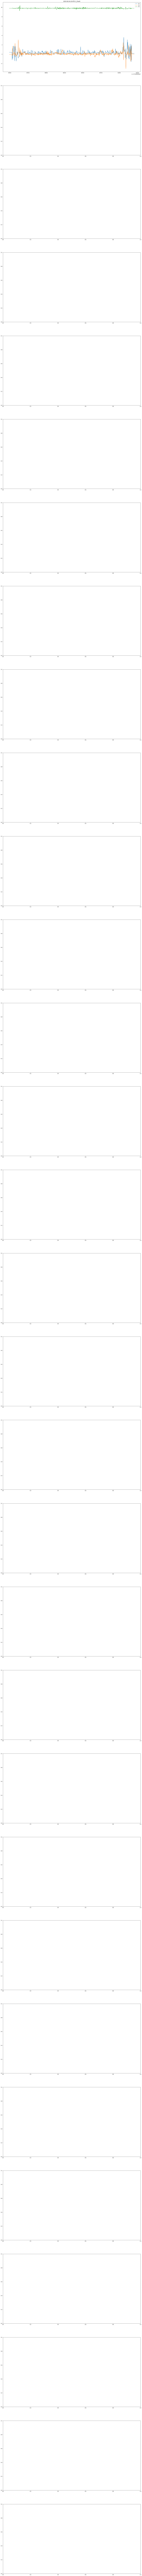

In [10]:
train_df_path = "/work/data/input/selfmade_dataset/baseline_with_derived_data_v2/train.pkl";
train_df = load_pickle_data(train_df_path)


logg_paths = train_df["phone"].unique().tolist()[:30]


fig,ax = plt.subplots(len(logg_paths)+1, 1, figsize=(25,16*len(logg_paths)))



idx = 0;
for target in tqdm(logg_paths[:1]):
    col = target.split("_")[0]
    ph = target.split("_")[1]    
    
    try: 
        s = get_direction_by_magn(train_df,col,ph)

        ax[idx].plot(s["millisSinceGpsEpoch"],s["x_f"] ,label="mx")
        ax[idx].plot(s["millisSinceGpsEpoch"],s["y_f"], label="my")
        ax[idx].plot(s["millisSinceGpsEpoch"],s["z_f"], label="mz")

        #ax[2*idx+1].plot(s["millisSinceGpsEpoch"],s["global_mx"].diff(),label="diff_mx")
        #ax[2*idx+1].plot(s["millisSinceGpsEpoch"],s["global_my"].diff(), label="diff_my")
        #ax[2*idx+1].plot(s["millisSinceGpsEpoch"],s["global_mz"].diff(), label="diff_mz")

        ax[idx].legend()
        ax[idx].set_title(target)
    except Exception:
        print("target")
        pass;
    
    #ax[2*idx+1].legend()
    #ax[2*idx+1].set_title(target)
    
    idx  = idx+1;
    
    